# Project Description

Use data collected from a Samsung health app to draw relevant conclusions.

#### Files:
+ [sleep-export2.csv](https://www.dropbox.com/s/7fdmc0l3410g8hu/sleep-export2.csv?dl=0)
+ [exercise.csv](https://www.dropbox.com/s/swvtjxw2ilcn4pl/exercise.csv?dl=0)
+ [heart_rate.csv](https://www.dropbox.com/s/7h2sphkvf4cjbsh/heart_rate.csv?dl=0)
+ [Step_Count](https://www.dropbox.com/s/4edk6mwwsb6dogp/step_co7unt.csv?dl=0)
+ [Floors_climbed](https://www.dropbox.com/s/wyde3yf57gurp1v/floors_climbed.csv?dl=0)

#### Jupyter Notebook:
+ Set up
  + Imports
  + Define Retrieve_Data class
  + Define relevant functions
+ Preprocess each data file individually
  + Convert time labels to meaningful format
  + Create coarse features, such as
    + Sleep hour
    + Day of the week
    + Time since timezone has changed
+ Merge data from the multiple sources
+ Analyze individual files
+ Analyze the combined data
+ Conclusions
+ Questions I will attempt to address

#### Samsung app documentation:
+ [Technical details](https://developer.samsung.com/html/techdoc/ProgrammingGuide_SHealthService.pdf)
+ [Property description](https://developer.samsung.com/onlinedocs/health/index.html?com/samsung/android/sdk/healthdata/HealthConstants.Sleep.html)
+ [Health data](https://developer.samsung.com/onlinedocs/health/index.html?com/samsung/android/sdk/healthdata/HealthConstants.html)

#### Notes:
+ The reported times are all measured at the UTC timezone. They are corrected for the local time for these analyses. (See Field Detail - START_TIME in the app [documentation](https://developer.samsung.com/onlinedocs/health/index.html?com/samsung/android/sdk/healthdata/HealthConstants.Sleep.html).
+ A floor is 3m.
+ Units are typical in internation units.


---
# Set up
+ Imports
+ Define Retrieve_Data class
+ Define Merge_Data class
---

#### Imports

In [75]:
import sys
import os
import calendar
import numpy as np
import pandas as pd
import seaborn as sns
import importlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator
from datetime import datetime
from datetime import timedelta
from dateutil import tz
from collections import Counter
%matplotlib inline

#Set matplotlib variables for prettier plots.
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
fs = 20.

#Set seaborn fontsize and line width.
sns.set_context('notebook', font_scale=1.5, rc={'lines.linewidth': 2.5})

#### Rerieve_Time

In [2]:
class Retrieve_Timestamps(object):
    """
    Description:
    ------------
    Given a list of time strings, convert it to a datetime object which is in the
    local timezone.
    """        
    def __init__(self, target, tz_true, tz_used, inp_format, time_format):
        self.target = target
        self.tz_true = tz_true
        self.tz_used = tz_used
        self.inp_format = inp_format
        self.time_format = time_format
        
        self.out = None
        self.time_obj = None
                
        self.create_date_obj()
        self.get_corrected_timeobj()

    def create_date_obj(self):
        if self.inp_format == 'datestr':
            self.time_obj = np.array(
              [datetime.strptime(t, self.time_format) for t in self.target])
        elif self.inp_format == 'milisec':
            self.time_obj = np.array(
              [datetime.fromtimestamp(t) for t in self.target])            
        else:
            raise ValueError('inp_format of %s is not accepeted.'\
                             %(self.inp_format))

    def get_corrected_timeobj(self):
        from_zone = tz.gettz(self.tz_used)
        to_zone = [tz.gettz(t_off) for t_off in self.tz_true]
        
        #The timezone information below is erased for compatibility with pandas resample.
        self.out = np.array([_t.replace(tzinfo=from_zone).astimezone(_to_zone).replace(tzinfo=None)
                            for (_t,_to_zone) in zip(self.time_obj,to_zone)])

#Run tests
def run_tests():
    assert\
        Retrieve_Timestamps(['2018-04-07 17:26:10'], 'UTC', 'UTC-0200', 'datestr', '%Y-%m-%d %H:%M:%S').out\
        == [datetime(2018, 4, 7, 15, 26, 10)], ValueError('Time conversion not working.')
    assert\
        Retrieve_Timestamps([1326244364], 'UTC', 'UTC-0200', 'milisec', '%Y-%m-%d %H:%M:%S').out\
        == [datetime(2012, 1, 10, 17, 12, 44)], ValueError('Time conversion not working.')
    
run_tests()

#### Functions

In [3]:
#Get quantiles
def get_quantiles(var_name, inp_array):
    """Get quantiles of a given array. Print median
    and 1-sigma interval. 
    """
    q = np.quantile(inp_array, np.array([0.16,0.5,0.84]))
    print('median of %s is %.2f with an 86%% interval of (%.2f,%.2f)' %(var_name, q[1], q[0], q[2]))

In [4]:
weekday_str2num = {'Sunday':1, 'Monday':2, 'Tuesday':3, 'Wednesday':4,
                   'Thursday':5, 'Friday':6, 'Saturday':7}

#https://developer.samsung.com/onlinedocs/health/EXERCISE_TYPE.html
exertype_num2str = {1001:'Walking', 0:'Custom', 14001:'Swimming',
                    1002:'Running', 11007:'Cycling', 13001:'Hiking',
                    15006:'Elliptical'}


---
# Pre-process: sleep data
---

#### Retrieve data

In [5]:
fpath = './data/sleep-export2.csv'
sleep_df = pd.read_csv(fpath, header=0, index_col=0, low_memory=False)

#Rename columns for simplicity.
newcols = {col : col.replace('com.samsung.health.sleep.', '') for col in sleep_df.columns}
sleep_df.rename(columns=newcols, inplace=True)    

#### Preprocess data

In [6]:
#Use the Retrieve_Timestamps class to convert timestamps to readable values.
time_format = '%Y-%m-%d %H:%M:%S.%f'
starttime_obj = Retrieve_Timestamps(
  sleep_df['start_time'].values/1000., sleep_df['time_offset'].values, 'UTC', 'milisec', time_format).out
endtime_obj = Retrieve_Timestamps(
  sleep_df['end_time'].values/1000., sleep_df['time_offset'].values, 'UTC', 'milisec', time_format).out
sleep_df['Start_time_obj'] = starttime_obj

#Compute the measurement date (without including hour--for merging purposes).
sleep_df['date'] = np.array([t.strftime('%Y/%m/%d') for t in starttime_obj])

#Compute hour of the day the measurement started.
sleep_df['start_hour'] = np.array([t.hour + t.minute/60. + t.second/3600. for t in starttime_obj])
sleep_df['end_hour'] = np.array([t.hour + t.minute/60. + t.second/3600. for t in endtime_obj])

#Compute day of the week.
sleep_df['weekday'] = np.array([calendar.day_name[t.weekday()] for t in starttime_obj])
sleep_df['weekday_num'] = sleep_df['weekday'].map(weekday_str2num) 


#Compute sleep duration.
duration = endtime_obj - starttime_obj
sleep_df['sleep_duration'] = np.array([t.days*24. + t.seconds/3600. for t in duration]) #In hours

#Compute time progression.
ref_date = min(starttime_obj)
time_prog = starttime_obj - ref_date
sleep_df['time_prog'] = np.array([t.days + t.seconds/86400. for t in time_prog]) #In days

#Sort sleep data according to time progression.
sleep_df.sort_values(by ='time_prog', inplace=True)

print('Start date: ', (min(starttime_obj)))
print('End date: ', (max(starttime_obj)))

Start date:  2017-12-15 20:02:00
End date:  2018-07-28 21:04:00


In [7]:
#Compute time elapsed since a timezone change.
#Compute number of days since time zone change.
time_since = 0.
tz_duration = []
for ((index2,row2),(index1,row1)) in zip(sleep_df.shift(1).iterrows(),sleep_df.iterrows()):
    if row1['time_offset'] == row2['time_offset']:
        time_since += (row1['time_prog'] - row2['time_prog']) #Additional time transpired since the tz changed.
    else:
        time_since = 0.
    tz_duration.append(time_since)

tz_duration = np.array(tz_duration)    

#We do not need tz_duration to be fine for plotting purposes.
def coarsify_duration(x):
    if x <= 2.:
        return 'tz < 2'
    elif (x > 2.) and (x <= 5.):
        return '2 < tz < 5'
    elif (x > 5.):
        return 'tz > 5'
tz_duration = [coarsify_duration(tz) for tz in tz_duration]
#We don't know for how long the person had been on the initial time zone.
tz_duration[0:3] = [np.nan, np.nan, np.nan]
sleep_df['tz_duration'] = tz_duration

---
# Pre-process: Exercise
---

#### Retrieve data

In [8]:
fpath = './data/exercise.csv'
exer_df = pd.read_csv(fpath, header=0, index_col=0, low_memory=False)

#### Preprocess data

In [9]:
time_format = '%Y-%m-%d %H:%M:%S.%f'
#Use the Retrieve_Timestamps class to convert timestamps to readable values.
starttime_obj = Retrieve_Timestamps(
  exer_df['start_time'].values, exer_df['time_offset'].values, 'UTC', 'datestr', time_format).out
endtime_obj = Retrieve_Timestamps(
  exer_df['end_time'].values, exer_df['time_offset'].values, 'UTC', 'datestr', time_format).out
exer_df['Start_time_obj'] = starttime_obj

#Show that time conversion makes sense.
print(exer_df['start_time'].values[0], exer_df['time_offset'].values[0], starttime_obj[0])

#Compute the measurement date (without including hour--for merging purposes).
exer_df['date'] = np.array([t.strftime('%Y/%m/%d') for t in starttime_obj])

#Compute duration. This is, supposedly always 1min.
duration = endtime_obj - starttime_obj
exer_df['exer_duration'] = np.array([t.days*24.*60 + t.seconds/60. for t in duration]) #In minutes

#Compute hour of the day the measurement started.
exer_df['start_hour'] = np.array([int(t.hour + t.minute/60. + t.second/3600.) for t in starttime_obj])

#Compute day of the week.
exer_df['weekday'] = np.array([calendar.day_name[t.weekday()] for t in starttime_obj])
exer_df['weekday_num'] = exer_df['weekday'].map(weekday_str2num) 

#Compute time progression.
ref_date = min(starttime_obj)
time_prog = starttime_obj - ref_date
exer_df['time_prog'] = np.array([t.days + t.seconds/86400. for t in time_prog]) #In days

#Convert exercise type to readable format.
exer_df['exercise'] = exer_df['exercise_type'].map(exertype_num2str)

#Sort sleep data according to time progression.
exer_df.sort_values(by ='time_prog', inplace=True)

print('Start date: ', (min(starttime_obj)))
print('End date: ', (max(starttime_obj)))

#Note: The duration seems to be a fixed small interval, which
#indicates that the heart_rate entry is the instantaneous heart_rate
#at the start time.

2018-04-07 17:26:10.149 UTC-0300 2018-04-07 14:26:10.149000
Start date:  2016-06-25 04:28:30.517000
End date:  2018-05-03 05:04:31


# Pre-process: Steps

#### Retrieve data

In [10]:
fpath = './data/step_count.csv'
step_df = pd.read_csv(fpath, header=0, index_col=0, low_memory=False)

#### Preprocess data


In [11]:
#Use the Retrieve_Timestamps class to convert timestamps to readable values.
time_format = '%Y-%m-%d %H:%M:%S.%f'
starttime_obj = Retrieve_Timestamps(
  step_df['start_time'].values, step_df['time_offset'].values, 'UTC', 'datestr', time_format).out
endtime_obj = Retrieve_Timestamps(
  step_df['end_time'].values, step_df['time_offset'].values, 'UTC', 'datestr', time_format).out
step_df['Start_time_obj'] = starttime_obj

#Compute the measurement date (without including hour--for merging purposes).
step_df['date'] = np.array([t.strftime('%Y/%m/%d') for t in starttime_obj])

#Compute hour of the day the measurement started.
step_df['start_hour'] = np.array([t.hour + t.minute/60. + t.second/3600. for t in starttime_obj])
step_df['end_hour'] = np.array([t.hour + t.minute/60. + t.second/3600. for t in endtime_obj])

#Compute day of the week.
step_df['weekday'] = np.array([calendar.day_name[t.weekday()] for t in starttime_obj])
step_df['weekday_num'] = step_df['weekday'].map(weekday_str2num) 

#Compute sleep duration.
duration = endtime_obj - starttime_obj
step_df['step_duration'] = np.array([t.days*24. + t.seconds/3600. for t in duration]) #In hours

#Compute time progression.
ref_date = min(starttime_obj)
time_prog = starttime_obj - ref_date
step_df['time_prog'] = np.array([t.days + t.seconds/86400. for t in time_prog]) #In days

#Sort sleep data according to time progression.
step_df.sort_values(by ='time_prog', inplace=True)

print('Start date: ', (min(starttime_obj)))
print('End date: ', (max(starttime_obj)))

Start date:  2018-03-31 04:01:00
End date:  2018-05-03 06:17:00


In [12]:
#Aggregate the data according to date.
aggregator = {'distance':'sum', 'step_duration':'sum', 'speed':'mean',
              'calorie':'sum', 'count':'sum', 'weekday_num':'first'}
step_agg_df = step_df.resample('15T', on='Start_time_obj').agg(aggregator)
step_agg_df = step_agg_df.reset_index()

---
# Pre-process: Heart rate
---

#### Retrieve data

In [13]:
fpath = './data/heart_rate.csv'
heart_df = pd.read_csv(fpath, header=0, index_col=0, low_memory=False)

#### Preprocess data


In [14]:
time_format = '%Y-%m-%d %H:%M:%S.%f'
#Use the Retrieve_Timestamps class to convert timestamps to readable values.
starttime_obj = Retrieve_Timestamps(
  heart_df['start_time'].values, heart_df['time_offset'].values, 'UTC', 'datestr', time_format).out
#The two earliest dates seem spurious. Remove them.
heart_df = heart_df.drop(heart_df[heart_df.start_time == min(heart_df.start_time)].index)

#Re-calculate datetime objects without the spurious entries.
starttime_obj = Retrieve_Timestamps(
  heart_df['start_time'].values, heart_df['time_offset'].values, 'UTC', 'datestr', time_format).out
endtime_obj = Retrieve_Timestamps(
  heart_df['end_time'].values, heart_df['time_offset'].values, 'UTC', 'datestr', time_format).out
heart_df['Start_time_obj'] = starttime_obj

#Compute the measurement date (without including hour--for merging purposes).
heart_df['date'] = np.array([t.strftime('%Y/%m/%d') for t in starttime_obj])

#Compute hour of the day the measurement started.
heart_df['start_hour'] = np.array([t.hour + t.minute/60. + t.second/3600. for t in starttime_obj])

#Compute day of the week.
heart_df['weekday'] = np.array([calendar.day_name[t.weekday()] for t in starttime_obj])
heart_df['weekday_num'] = heart_df['weekday'].map(weekday_str2num) 

#Compute time progression.
ref_date = min(starttime_obj)
time_prog = starttime_obj - ref_date
heart_df['time_prog'] = np.array([t.days + t.seconds/86400. for t in time_prog]) #In days

#Sort sleep data according to time progression.
heart_df.sort_values(by ='time_prog', inplace=True)

print('Start date: ', (min(starttime_obj)))
print('End date: ', (max(starttime_obj)))

#Note: The duration seems to be a fixed small interval, which
#indicates that the heart_rate entry is the instantaneous heart_rate
#at the start time.

Start date:  2016-06-09 20:11:04.783000
End date:  2018-04-25 14:46:13.476000


In [15]:
#Aggregate the data according to date.
aggregator = {'time_prog':'mean', 'heart_rate':'mean', 'weekday':'first',
              'weekday_num':'first', 'date':'first', 'time_offset':'first'}
heart_agg_df = heart_df.resample('D', on='Start_time_obj').agg(aggregator)
heart_agg_df = heart_agg_df.reset_index()

---
# Pre-process: Floors climbed
---

#### Retrieve data

In [16]:
fpath = './data/floors_climbed.csv'
floor_df = pd.read_csv(fpath, header=0, index_col=0, low_memory=False)

#### Preprocess data


In [17]:
#Use the Retrieve_Timestamps class to convert timestamps to readable values.
starttime_obj = Retrieve_Timestamps(
  floor_df['start_time'].values, floor_df['time_offset'].values, 'UTC', 'datestr', time_format).out
endtime_obj = Retrieve_Timestamps(
  floor_df['end_time'].values, floor_df['time_offset'].values, 'UTC', 'datestr', time_format).out
floor_df['Start_time_obj'] = starttime_obj

#Compute the measurement date (without including hour--for merging purposes).
floor_df['date'] = np.array([t.strftime('%Y/%m/%d') for t in starttime_obj])

#Compute hour of the day the measurement started.
floor_df['start_hour'] = np.array([t.hour + t.minute/60. + t.second/3600. for t in starttime_obj])

#Compute day of the week.
floor_df['weekday'] = np.array([calendar.day_name[t.weekday()] for t in starttime_obj])
floor_df['weekday_num'] = floor_df['weekday'].map(weekday_str2num) 

#Compute duration. This is, supposedly always 1min.
duration = endtime_obj - starttime_obj
floor_df['floor_duration'] = np.array([t.days*24.*60 + t.seconds/60. for t in duration]) #In minutes

#Compute time progression.
ref_date = min(starttime_obj)
time_prog = starttime_obj - ref_date
floor_df['time_prog'] = np.array([t.days + t.seconds/86400. for t in time_prog]) #In days

#Sort floors data according to time progression.
floor_df.sort_values(by ='time_prog', inplace=True)

print('Start date: ', (min(starttime_obj)))
print('End date: ', (max(starttime_obj)))

Start date:  2017-12-16 04:46:12
End date:  2018-05-03 05:13:11


In [18]:
#Get a coarse number of floors for vizualiation purposes.
def coarsify_floors(x):
    if np.isnan(x):
        return np.nan
    elif x <= 1.:
        return 'h < 3m'
    elif (x > 1.) and (x <= 2.):
        return '3m < h < 6m'
    elif (x > 2.) and (x <= 3.):
        return '6m < h < 9m'
    elif (x > 3.):
        return 'h > 9m'
floors = [coarsify_floors(f) for f in floor_df['floor'].values]
floor_df['floor_coarse'] = floors

In [19]:
#Aggregate the data according to date.
#aggregator = {'floor':'sum', 'floors_duration':'sum', 'date':'first',
#              'weekday':'first', 'time_offset':'first'}
#floor_agg_df = floor_df.resample('D', on='Start_time_obj').agg(aggregator)
#floor_agg_df = floor_agg_df.reset_index()
#print(floor_agg_df.columns)
#floor_agg_df = floor_agg_df.dropna(subset=['date'])

---
# Overlapping Time
---

/home/heringer/anaconda2/envs/py37/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


<Figure size 432x288 with 0 Axes>

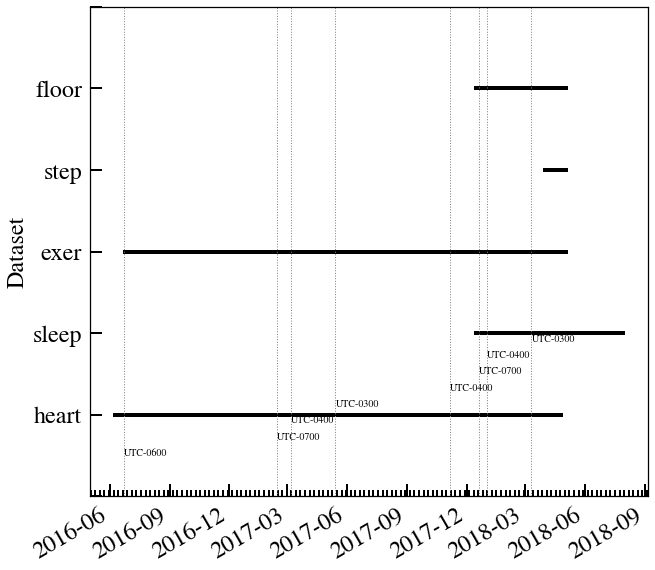

In [20]:
import matplotlib.dates as mdates

def add_tz_change(ax, time_obj, tz_list):
    p = 0.5
    cond = tz_list[:-1] != tz_list[1:]
    for t, tz in zip(time_obj[1:][cond], tz_list[1:][cond]):
        ax.axvline(t, ls=':', lw=1, color='grey')
        ax.text(t, p, tz, fontsize=10.)
        p += 0.2
    
plt.clf()
fig, ax = plt.subplots(1,1, figsize=(10,10))

x_label = r'Time'
y_label = r'Dataset'
ax.set_xlabel('', fontsize=fs)
ax.set_ylabel(y_label, fontsize=fs)
ax.set_ylim(0., 6.)
ax.tick_params(axis='y', which='major', labelsize=fs, pad=8)      
ax.tick_params(axis='x', which='major', labelsize=fs, pad=8)
ax.tick_params(
  'both', length=12, width=2., which='major', direction='in')
ax.tick_params(
  'both', length=6, width=2., which='minor', direction='in')    
ax.yaxis.set_major_locator(MultipleLocator(1.)) 

list_df = [heart_df, sleep_df, exer_df, step_df, floor_df]
list_suffix = ['heart', 'sleep', 'exer', 'step', 'floor']

ylabels = ['', '']
complete_tz, complete_t = [], []
for i, (df,suffix) in enumerate(zip(list_df, list_suffix)):
    ylabels.append(suffix)
    time_obj = df['Start_time_obj'].values
    x = [min(time_obj), max(time_obj)]
    y = [i + 1, i + 1]
    ax.plot(x, y, marker='None', ls='-', lw=4., color='k')
    complete_t += list(time_obj)
    complete_tz += list(df['time_offset'].values)
ax.set_yticklabels(ylabels)

#Add vertical lines where timezone has changed.
#use a compile list containing all time objects and their respective timezones.
aux_df = pd.DataFrame({'time':complete_t, 'tz':complete_tz})
aux_df.sort_values(by ='time', inplace=True)
add_tz_change(ax, aux_df['time'].values, aux_df['tz'].values)

ax.xaxis.set_minor_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
fig.autofmt_xdate()

---
# Merge data
---

In [21]:
#Temp - for assignment 5.

#master_df = pd.merge(sleep_agg_df, floor_agg_df, how='left', on='date')
#master_df = pd.merge(sleep_agg_df, floor_agg_df, how='left', on=['date', 'weekday'])
#print(master_df.shape)
#print(sleep_agg_df.shape)
#print(floor_agg_df.shape)
#print(master_df.columns)
#master_df

In [22]:
#Derive quantities for merged data. This avoids confusion in trying
#to merge these quantities from the original data sets.

---
# Analysis: Individual files
---

## Sleep: Corner Plot

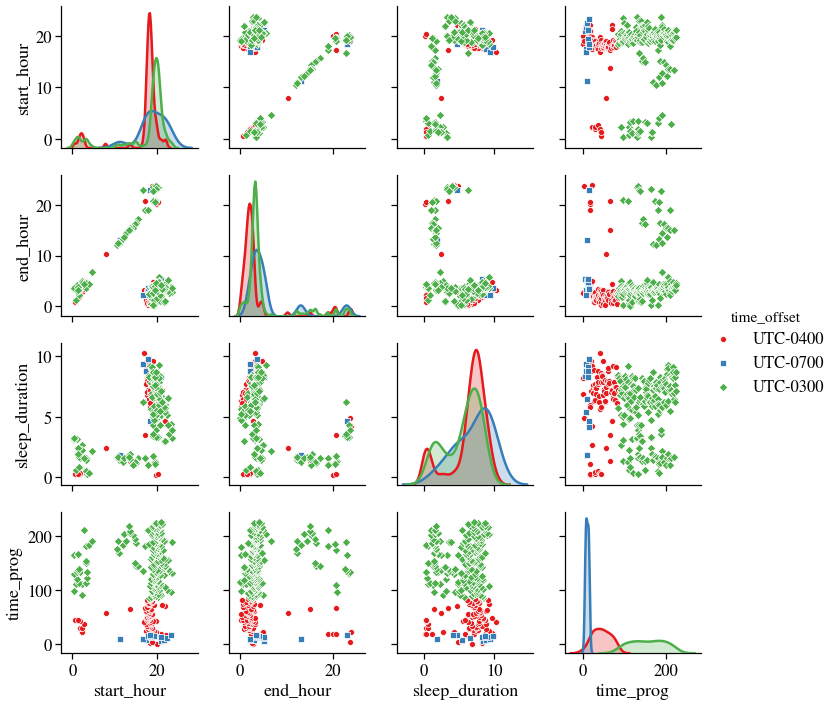

In [23]:
palette = ['#e41a1c','#377eb8','#4daf4a'] #From colorbrewer
pair_cols = ['start_hour', 'end_hour', 'sleep_duration', 'time_prog', 'time_offset']
g = sns.pairplot(sleep_df[pair_cols], hue='time_offset', markers=["o", "s", "D"],
                 palette=palette)

In [24]:
#palette = ['#e41a1c','#377eb8','#4daf4a'] #From colorbrewer
#pair_cols = ['start_hour', 'end_hour', 'sleep_duration', 'time_prog', 'tz_duration']
#g = sns.pairplot(sleep_df[pair_cols], hue='tz_duration', markers=["o", "s", "D"],
#                 palette=palette)

## Sleep: Bedtime (hour of the day) vs day of the week

median of Bedtime is 19.25 with an 86% interval of (15.01,20.71)
median of Wake-up time is 3.22 with an 86% interval of (1.92,5.03)


<Figure size 432x288 with 0 Axes>

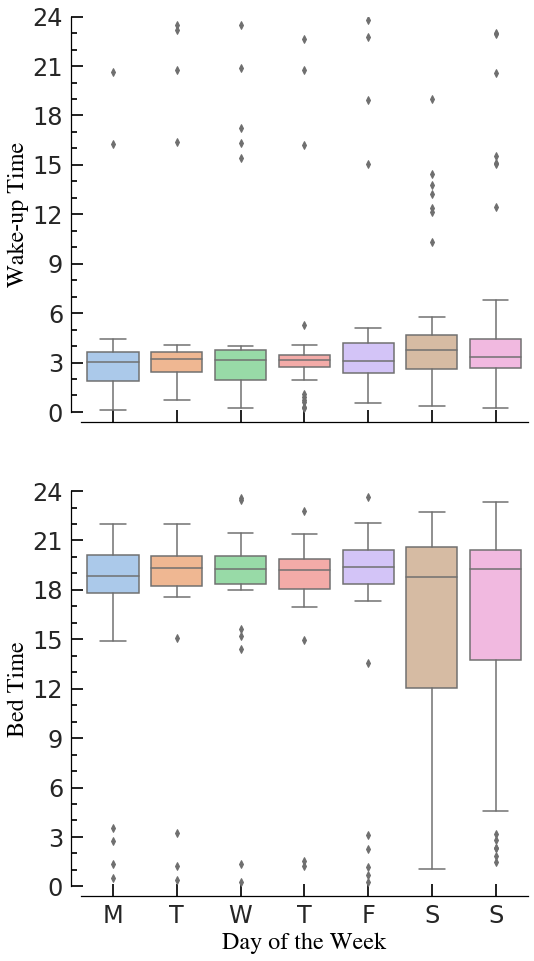

In [25]:
#Trim data by removing recent timezone changes.
aux_df = sleep_df[sleep_df['tz_duration'] == 'tz > 5']

#Make plots.
plt.clf()
fig, (ax1, ax2) = plt.subplots(
  2,1, gridspec_kw = {'height_ratios':[1, 1]}, figsize=(8,16))

sns.set(style='ticks', palette='pastel')
order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

g = sns.boxplot(x='weekday', y='end_hour', data=aux_df, ax=ax1, order=order)

g = sns.boxplot(x='weekday', y='start_hour', data=aux_df, ax=ax2, order=order)
g.set_xticklabels(['M', 'T', 'W', 'T', 'F', 'S', 'S'])

sns.despine(offset=10, trim=False)

y_label = r'Wake-up Time'
ax1.set_xlabel('', fontsize=fs)
ax1.set_ylabel(y_label, fontsize=fs)
ax1.set_ylim(0., 24.)
ax1.tick_params(axis='y', which='major', labelsize=fs, pad=8)      
ax1.tick_params(axis='x', which='major', labelsize=fs, pad=8)
ax1.tick_params(
  'both', length=12, width=2., which='major', direction='in')
ax1.tick_params(
  'both', length=6, width=2., which='minor', direction='in')    
ax1.yaxis.set_minor_locator(MultipleLocator(1.))
ax1.yaxis.set_major_locator(MultipleLocator(3.)) 
ax1.tick_params(labelbottom=False)  

x_label = r'Day of the Week'
y_label = r'Bed Time'
ax2.set_xlabel(x_label, fontsize=fs)
ax2.set_ylabel(y_label, fontsize=fs)
ax2.set_ylim(0., 24.)
ax2.tick_params(axis='y', which='major', labelsize=fs, pad=8)      
ax2.tick_params(axis='x', which='major', labelsize=fs, pad=8)
ax2.tick_params(
  'both', length=12, width=2., which='major', direction='in')
ax2.tick_params(
  'both', length=6, width=2., which='minor', direction='in')    
ax2.yaxis.set_minor_locator(MultipleLocator(1.))
ax2.yaxis.set_major_locator(MultipleLocator(3.))  

get_quantiles('Bedtime', sleep_df['start_hour'].values)
get_quantiles('Wake-up time', sleep_df['end_hour'].values)

## Exercise: Types of walking

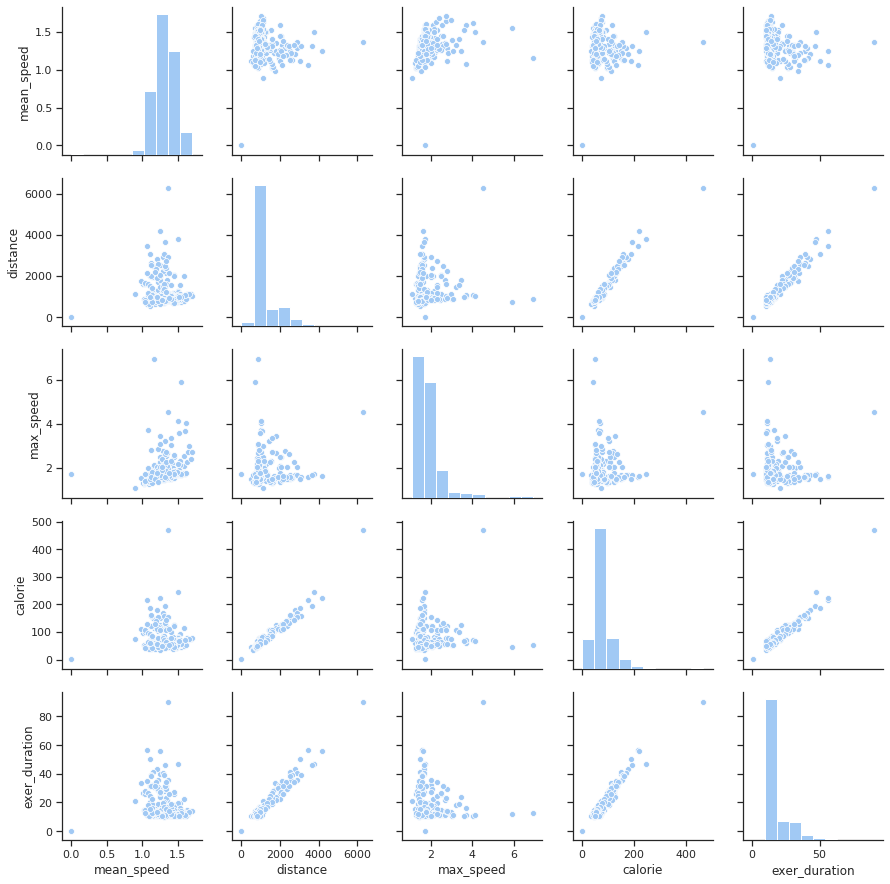

In [26]:
aux_df = exer_df[exer_df['exercise']=='Walking'][['mean_speed', 'distance', 'max_speed',
                                                  'calorie', 'exer_duration']].dropna()
sns.pairplot(aux_df)

In [27]:
def split_walking(exer, max_speed):
    if exer == 'Walking':
        if max_speed is np.nan:
            return nan
        elif max_speed < 2.5:
            return 'Casual walking'
        elif max_speed >= 2.5:
            return 'Fast walking'
    else:
        return exer
    
exer_df['exercise_up'] = [split_walking(e,s) for (e,s) in zip(exer_df['exercise'].values,
                                                              exer_df['max_speed'].values)]
#Uncomment to visually impact on the corner plot above.
#aux_df = exer_df[((exer_df['exercise_up']=='Casual walking') | (exer_df['exercise_up']=='Fast walking'))]    
#aux_df = aux_df[['mean_speed', 'distance', 'max_speed', 'calorie', 'exer_duration', 'exercise_up']].dropna()
#sns.pairplot(aux_df, hue='exercise_up')

## Exercise: Corner Plot

Counter({'Casual walking': 219, 'Custom': 40, 'Swimming': 30, 'Fast walking': 29, 'Running': 6, 'Hiking': 1, 'Cycling': 1})


/home/heringer/anaconda2/envs/py37/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/heringer/anaconda2/envs/py37/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


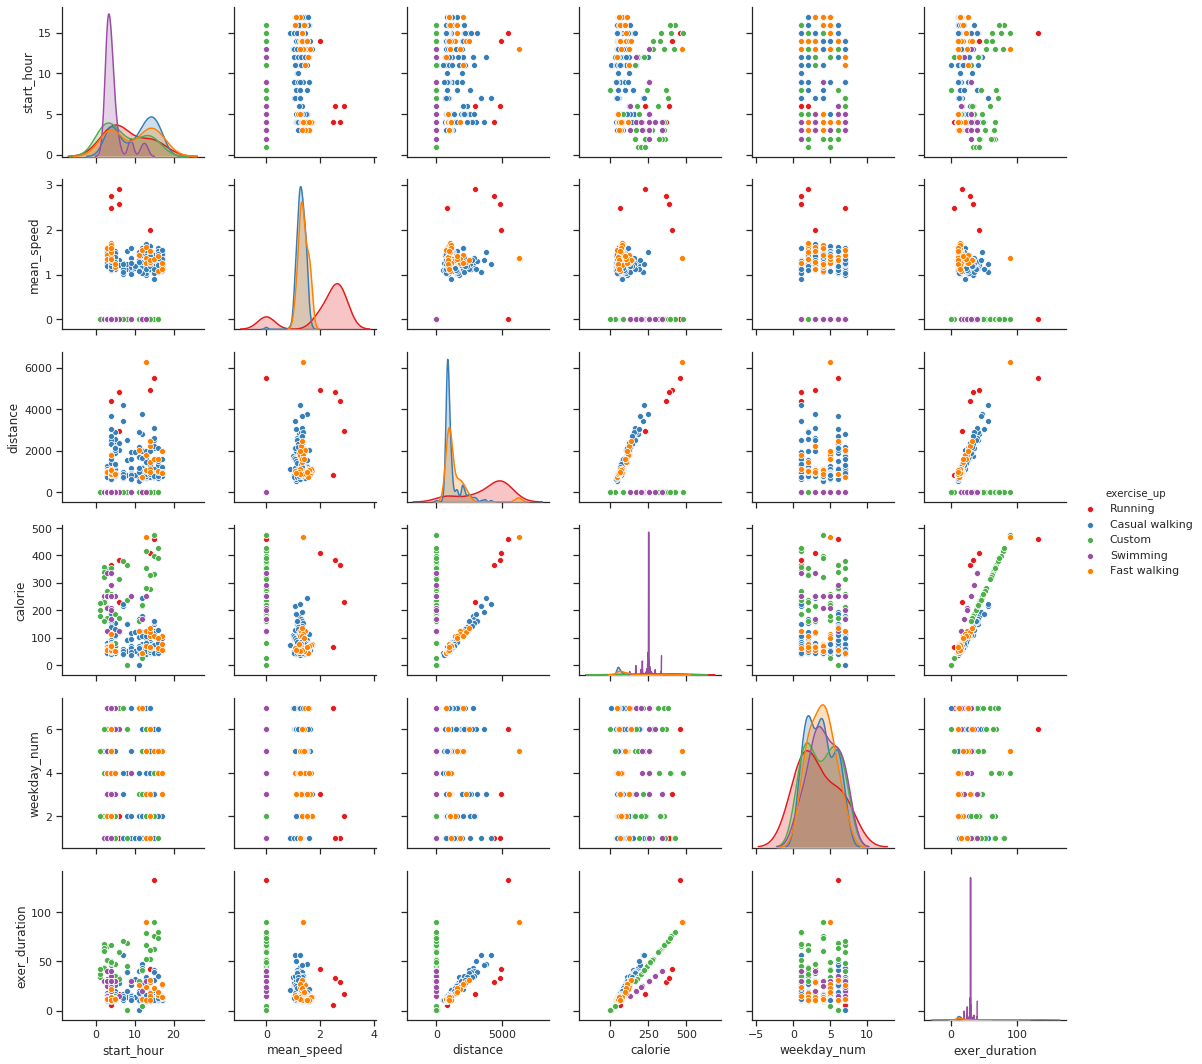

In [28]:
palette = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33'] #From colorbrewer
pair_cols = ['start_hour', 'mean_speed', 'distance', 'calorie',
             'weekday_num', 'exer_duration', 'exercise_up']
aux_df = exer_df[pair_cols].dropna()

print(Counter(aux_df['exercise_up'].values))
#Drop the two exercise types which have only one entry each.
aux_df.drop(aux_df[aux_df.exercise_up == 'Hiking'].index, inplace=True)
aux_df.drop(aux_df[aux_df.exercise_up == 'Cycling'].index, inplace=True)

g = sns.pairplot(aux_df[pair_cols], hue='exercise_up', palette=palette)

## Step: Corner plot

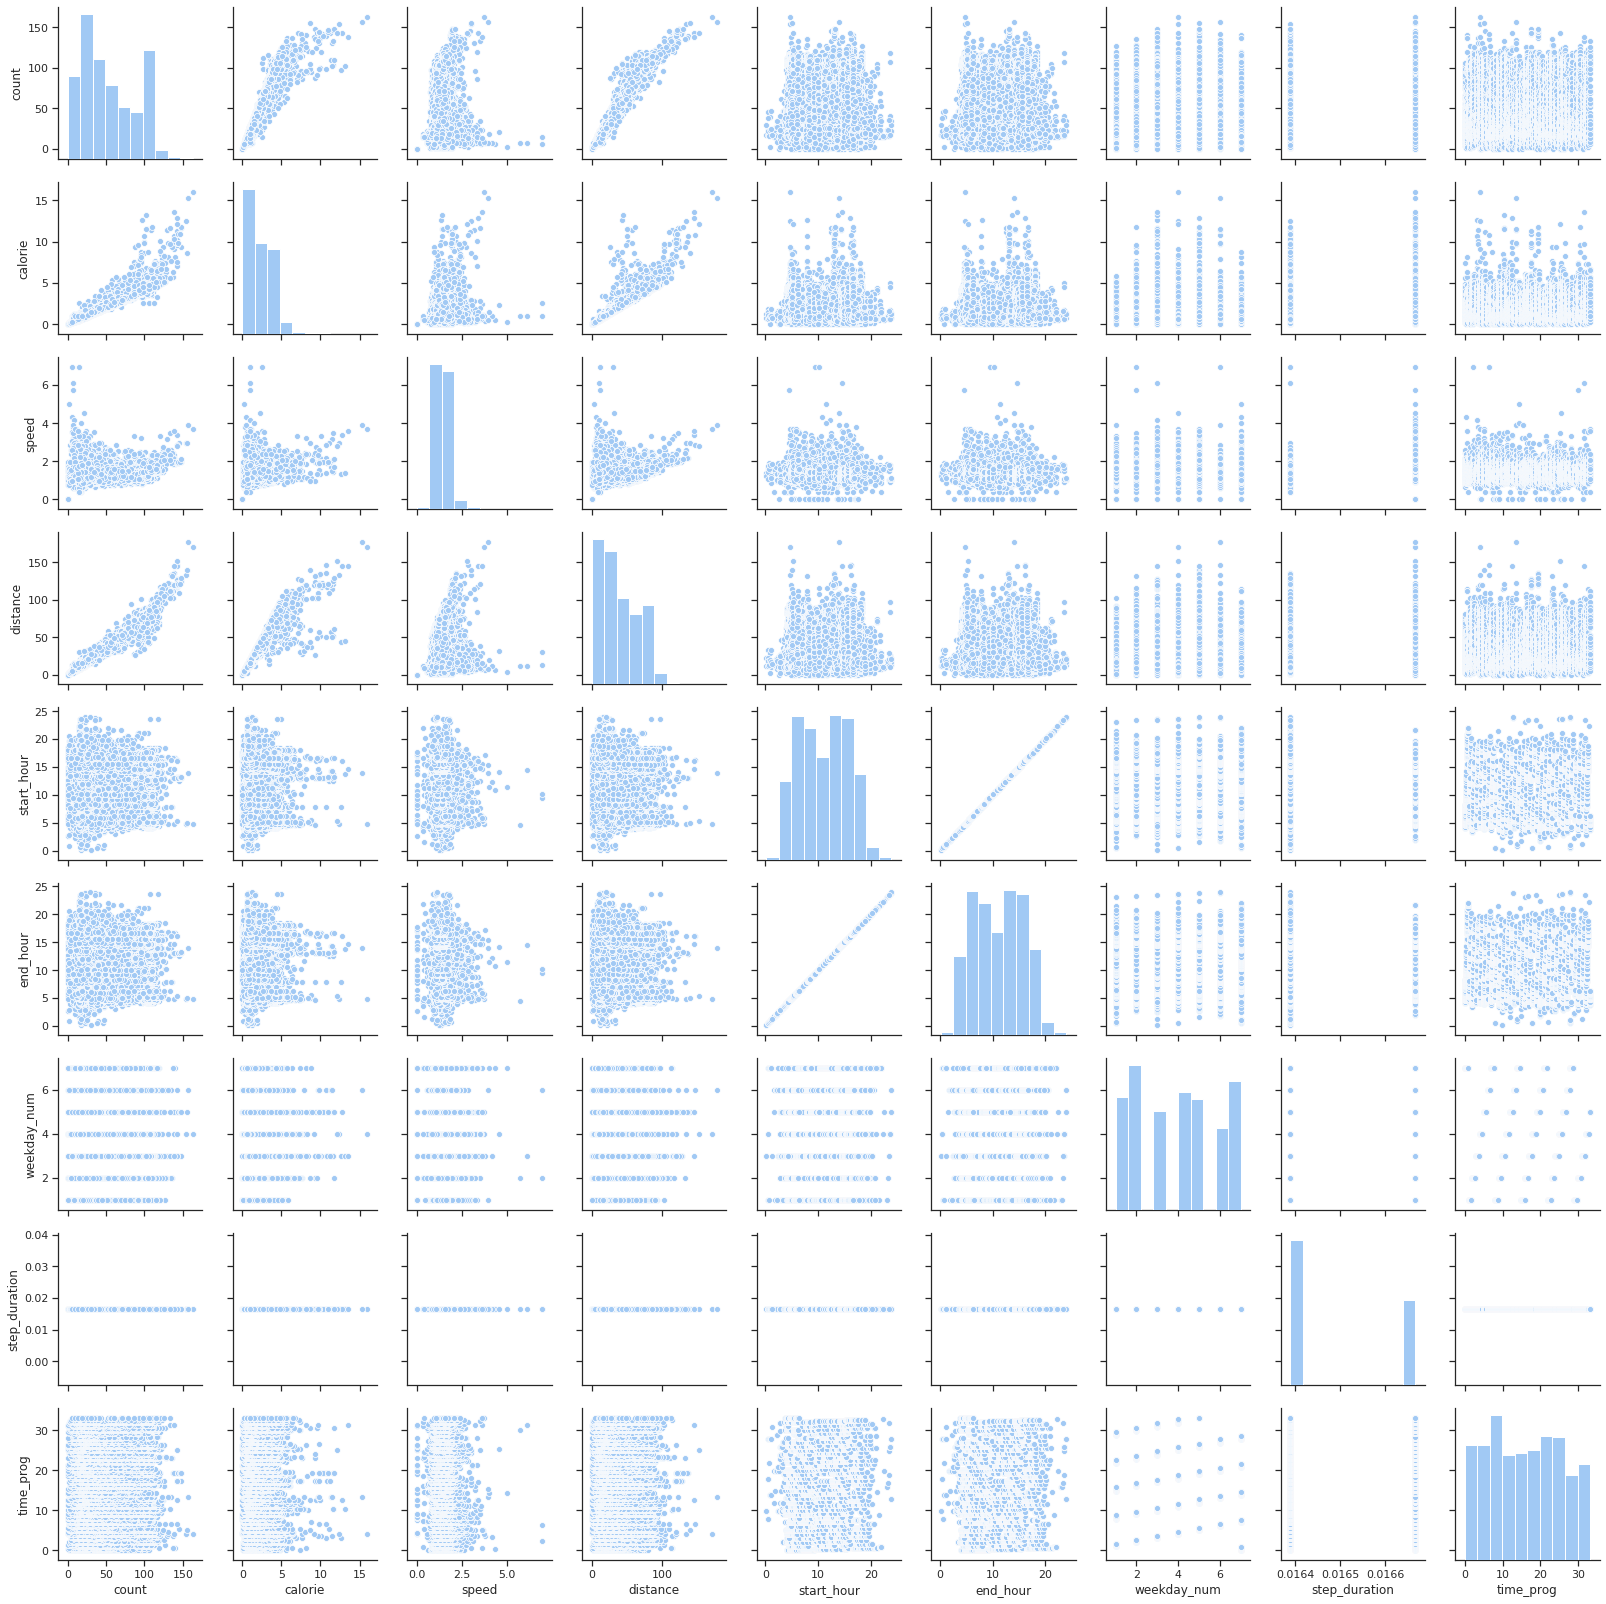

In [29]:
#Note, all entries are in the same timezone, UTC-0300
g = sns.pairplot(step_df)

## Heart: Corner plot

Index(['end_time', 'heart_rate', 'binning_data', 'start_time',
       'heart_beat_count', 'update_time', 'max', 'min', 'pkg_name',
       'time_offset', 'datauuid', 'create_time', 'Start_time_obj', 'date',
       'start_hour', 'weekday', 'weekday_num', 'time_prog'],
      dtype='object')


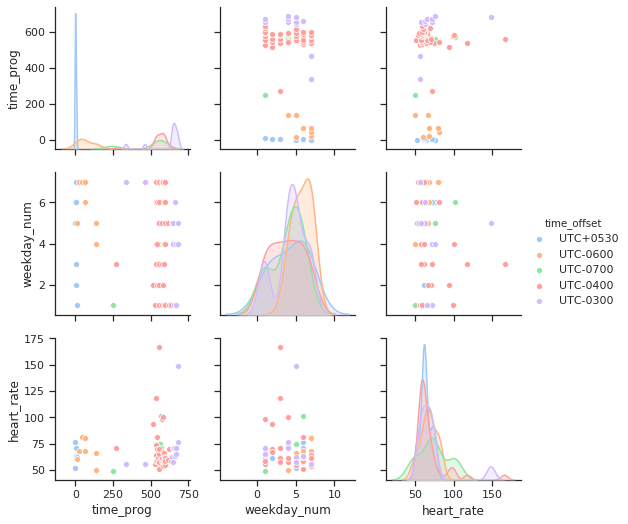

In [30]:
print(heart_df.columns)

pair_cols = ['time_prog', 'weekday_num', 'heart_rate', 'time_offset']
g = sns.pairplot(heart_agg_df[pair_cols], hue='time_offset')
#heart_df.describe()
#print(heart_agg_df)

In [31]:
get_quantiles('Heart rate', heart_df['heart_rate'].values)

median of Heart rate is 60.00 with an 86% interval of (52.00,72.00)


## Floors: Corner plot

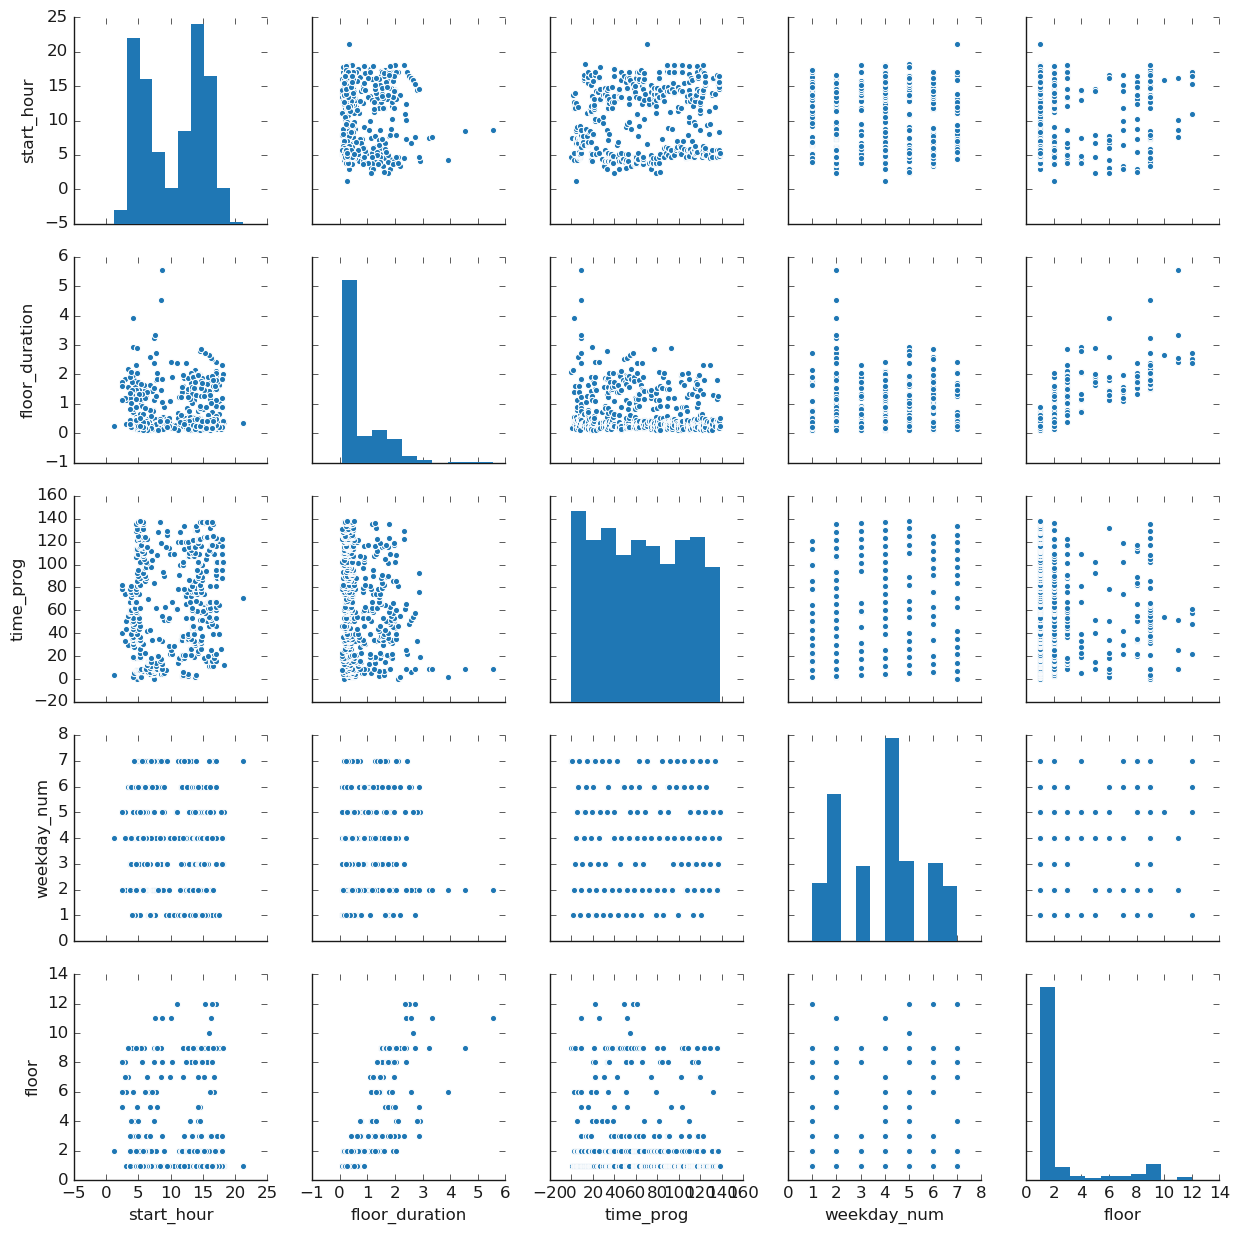

In [121]:
#Select relevant columns and make corner plot.
#aux_df = floor_df[floor_df['floor'] > 0.5]
#pair_cols = ['start_hour', 'floor_duration', 'time_prog', 'weekday_num']
#g = sns.pairplot(floor_df, vars=pair_cols, hue='floor_coarse')

pair_cols = ['start_hour', 'floor_duration', 'time_prog', 'weekday_num', 'floor']
g = sns.pairplot(floor_df, vars=pair_cols)

---
# Analysis: Combined data
---

## Typical routine

<Figure size 640x480 with 0 Axes>

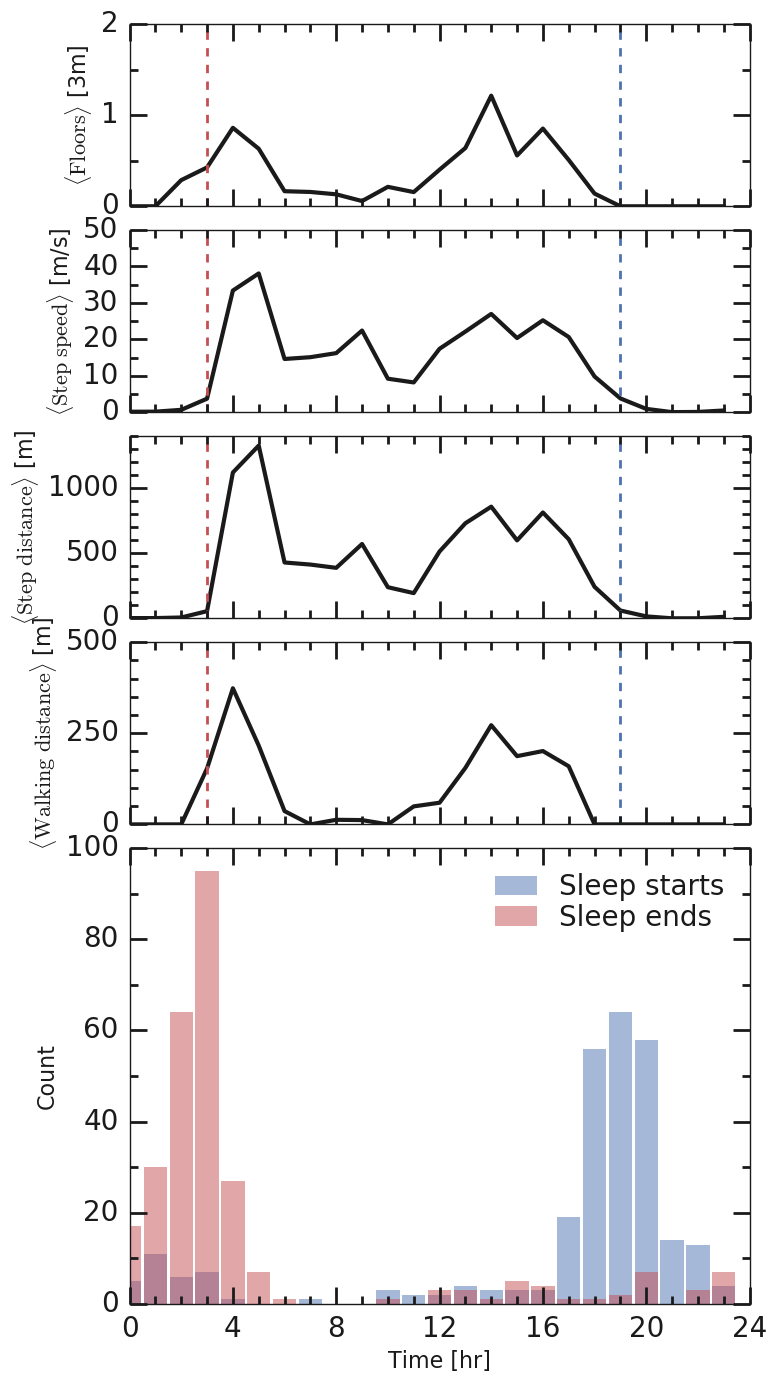

In [120]:
#The timezone difference in this subset happens at March 10th and is of
#1-hour. This is due to daylight saving hours changing.

def plot_hourly_mean(df, key, ax, p_args):
    P = '60T'
    t1 = pd.Timestamp('2018-01-01')
    
    
    #Simplify df.
    aux_df = df[['Start_time_obj', 'weekday_num', key]]
    cond = ((df['Start_time_obj'] > t1) & (df['weekday_num'] != 1) & (df['weekday_num'] != 7))
    aux_df = aux_df[cond]
    aux_df = aux_df.resample(P, on='Start_time_obj').agg({key:'sum'}).reset_index()
    aux_df['hour'] = aux_df['Start_time_obj'].dt.hour
    aux_df = aux_df.groupby(['hour'])
    aux_df = aux_df[key].mean().reset_index()
    #sns.lineplot(x='hour', y=key, data=aux_df, ax=ax)
    ax.plot(aux_df['hour'], aux_df[key], lw=3., color='k')

    #Treat subplot axis.
    ax.set_xlabel('', fontsize=fs)
    ax.set_ylabel(p_args[0], fontsize=fs - 4)
    ax.set_xlim(0., 24.)
    ax.set_ylim(p_args[1], p_args[2])
    ax.tick_params(axis='y', which='major', labelsize=fs, pad=8)      
    ax.tick_params(axis='x', which='major', labelsize=fs, pad=8)
    ax.tick_params(
      'both', length=12, width=2., which='major', direction='in')
    ax.tick_params(
      'both', length=6, width=2., which='minor', direction='in')    
    ax.xaxis.set_minor_locator(MultipleLocator(1.))
    ax.xaxis.set_major_locator(MultipleLocator(4.))
    ax.yaxis.set_minor_locator(MultipleLocator(p_args[3]))
    ax.yaxis.set_major_locator(MultipleLocator(p_args[4])) 
    ax.tick_params(labelbottom=False)  

    #Add vertical lines for typical wake-up and bed times.
    ax.axvline(x=wakeup, ls='--', color='r', lw=2.)
    ax.axvline(x=bedtime, ls='--', color='b', lw=2.)
    
#Make plots.
importlib.reload(mpl); importlib.reload(plt)
plt.clf()
#plt.style.use('classic')
#sns.set(style="white")
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(
  5,1, gridspec_kw = {'height_ratios':[1, 1, 1, 1, 2.5]}, figsize=(8,16))
plt.subplots_adjust(hspace=.1)

#Make histogram plot.
xlabel = r'Time [hr]'
ylabel = r'Count'
ax5.set_xlabel(xlabel, fontsize=fs - 4.)
ax5.set_ylabel(ylabel, fontsize=fs - 4.)
ax5.set_xlim(0., 24.)
#ax.set_ylim(25., 175.)
ax5.tick_params(axis='y', which='major', labelsize=fs, pad=8)      
ax5.tick_params(axis='x', which='major', labelsize=fs, pad=8)
ax5.tick_params('both', length=12, width=2., which='major',
                     direction='in', right=True, top=True)
ax5.tick_params('both', length=6, width=2., which='minor',
                     direction='in', right=True, top=True) 
ax5.xaxis.set_minor_locator(MultipleLocator(1.))
ax5.xaxis.set_major_locator(MultipleLocator(4.))
ax5.yaxis.set_minor_locator(MultipleLocator(10.))
ax5.yaxis.set_major_locator(MultipleLocator(20.))

#Plot data.
ax5.hist(sleep_df['start_hour'], bins=np.arange(0,24.1,1), align='left',
         rwidth=0.9, color='b', alpha=0.5, label='Sleep starts')
ax5.hist(sleep_df['end_hour'], bins=np.arange(0,24.1,1), align='left',
         rwidth=0.9, color='r', alpha=0.5, label='Sleep ends')
ax5.legend(
  frameon=False, fontsize=fs, labelspacing=.1, numpoints=1, loc=1,
  handlelength=1.5)
wakeup = 3.
bedtime = 19.

#make additional plots.
walking_df = exer_df[exer_df['exercise'] == 'Walking']
#plot_hourly_mean(heart_df, 'heart_rate', ax1, [r'$\langle \mathrm{Heart rate} \rangle$ [m]', 0., 100., 10., 50.])
plot_hourly_mean(floor_df, 'floor', ax1, [r'$\langle \mathrm{Floors} \rangle$ [3m]', 0., 2., .5, 1.])
plot_hourly_mean(step_df, 'speed', ax2, [r'$\langle \mathrm{Step\ speed} \rangle$ [m/s]', 0., 50., 5., 10.])
plot_hourly_mean(step_df, 'distance', ax3, [r'$\langle \mathrm{Step\ distance} \rangle$ [m]', 0., 1400., 100., 500.])
plot_hourly_mean(walking_df, 'distance', ax4, [r'$\langle \mathrm{Walking\ distance} \rangle$ [m]', 0., 500., 50., 250.])
#plot_hourly_mean(step_df, 'count', ax3, [r'$\langle \mathrm{Step} \rangle$ [m]', 0., 2000., 250, 1000.])
           


---
# Conclusions
---

+ Individual analyses

  + Sleep: Corner Plot
    + Typical sleep duration is ~8-9h, with the execption of a few naps that last ~1h.
    + Typical **bedtime is ~7-8pm** and typical **wake-up time is ~2-3am**.

  + Sleep: Bedtime (hour of the day) vs day of the week
    + On the days off (Saturday and Sunday--discussed below), they take naps during the day as well, making the bedtime distribution have a large variance.
    + On Saturdays, the bedtime can be as early as 3am (which is a typical wake-up time). Tihs may indicate the person sometimes goes to late-hour parties. This may further indicate a person in their **20's or 30's**.

  + Exercise: Corner Plot
    + Not much movement during certain times of weekdays. Person **likely has a desk job**. **Starts at 6am, lunch around 10am, ends around 2pm**. Saturday and Sunday are the days off. Person often has to walk fast to get to work, or take transit.
    + Distance peaks around 1000m, which is the likely distance from home to work, or to a bus/subway station. Most likely this person **walks ~1km to work**.

  + Heart: Corner plot
    + Heart rate is 60.50 with an 86% interval of (52.12,72.00).
      + If we believe this person to be younger than 40 (see above), then this person is likely a **woman**, because they tend to have a resting heart rate between 60 and 64 bpm, compared to 66 to 68 bpm for men (see [source](https://healthsolutions.fitbit.com/blog/resting-heart-rate/)).
    + The person has been more active in recent times.

  + Floors: Corner plot
    + Floors climbed exhibit two spikes as a faunction of hour of the day, around 8am and 1pm. This is slightly after and before the estimated work time, which is intriguing. Perhaps the work schedule is shorter and there is some commute time to be considered. In any case, this indicates that the person **works on the second floor**. Some floor activity around noon corroborates the idea of sporadically going out for lunch.

+ Combined data
  + Typical routine
    + This analysis cements that: person wakes up around **3am**, likely has a breakfast and **walks ~1km to work, arrving 5-6am**, **has a desk job**, sometimes goes out for **lunch around 12pm** and **leaves work 2-3pm**. There are typically **errands from 3 to 6pm**, coming back home at and going to **sleep around 7pm**. 



---
# Questions to address
---

+ Identify possible jobs that start so early in the morning.
+ How does changing the timezone affect the sleep duration.
+ Is this person healthy? Use a metric to combine exercise + steps.
+ Does this eprson live in a house or apartment? mayve floors data will help here.
+ Maybe PCA for types of walk?
+ Use same time as referece. Find earliest one is the heart one.
+ Where are the possible timezone locations.
+ remove holidays and visualize timezone changes
+ One could, in principle, look for indications of holidays in the data that do not match known national holidays and search for provincial/state holidays to pinpoint location. Perhaps difficult to disentangle from sick-days.
+ histogram of exercise times.
+ Combine exercise and heart.
